In [1]:
import pandas as pd
import numpy as np
import os
import folium # map rendering library
import json # library to handle JSON files
import requests # library to handle requests
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.pyplot as plt

In [2]:
# os.getcwd()
# Load in the main Census file with info of neighborhoods in Seattle
file = 'C:\\Users\\trang\Downloads\SeattleCensusBlocksandNeighborhoodCorrelationFile.xlsx'

In [3]:
xl = pd.ExcelFile(file)

In [4]:
print(xl.sheet_names)

['CENSUS_2010_BLOCKS']


In [5]:
df1 = xl.parse('CENSUS_2010_BLOCKS')

In [6]:
# Only keep columns that we're interested in
df2 = df1[['TRACT_10','BG','CRA_NO','CRA_NAME','NEIGHBORHOODS_INCLUDED','NEIGHBORHOOD_DISTRICT_NUMBER','NEIGHBORHOOD_DISTRICT_NAME']]

In [7]:
# Dedup
df3 = df2.drop_duplicates(keep='first')

In [8]:
# Read in dataset that contains latitude and longtitude 
df_geo= pd.read_csv("C:\\Users\\trang\Downloads\Census_Block_Groups_2010.csv")

In [9]:
df_geo2 = df_geo[['TRACTCE10','BLKGRPCE10','INTPTLAT10','INTPTLON10']]

In [10]:
# Attach geo info to the neighborhoods
df4 = pd.merge(df3, df_geo2, left_on=['TRACT_10','BG'], right_on=['TRACTCE10','BLKGRPCE10']).drop(['TRACTCE10','BLKGRPCE10'], axis=1)

In [11]:
# Read in demographic info
df_profile = pd.read_csv('C:\\Users\\trang\Downloads\Community_Reporting_Areas_Profile_ACS_5year_20132017.csv')

In [12]:
df_profile2 = df_profile[['CRA_NO','TOTAL_POPULATION','MEDIAN_AGE','PCT_NOTHISP_WHITE_ONE','PCT_NOTHISP_BLACK_ONE','PCT_NOTHISP_AMIAK_ONE','PCT_NOTHISP_ASIAN_ONE','PCT_NOTHISP_PI_ONE','PCT_NOTHISP_OTHER_ONE','PCT_NOTHISP_TWO_ONE','PCT_HISP_ANY_RACE','PCT_FAM_HH','AVERAGE_HOUSEHOLD_SIZE','MEDIAN_HH_INC_PAST_12MO_DOLLAR','PERCENT_UNEMPLOYED','POP_DENSITY_ACRE',]]

In [13]:
# Attach demographic info to the main dataframe 
df5 = pd.merge(df4, df_profile2, on=['CRA_NO'])

In [14]:
# Turn our focus into Ballard
ballard_data = df5[df5['NEIGHBORHOOD_DISTRICT_NAME'] == 'Ballard'].reset_index(drop=True)
ballard_address = 'Ballard, Seattle, US'

# get the geographical coordinates of Ballard
ballard_geolocator = Nominatim(user_agent="seattle_explorer")
ballard_location = ballard_geolocator.geocode(ballard_address)
ballard_latitude = ballard_location.latitude
ballard_longitude = ballard_location.longitude
print('The geograpical coordinate of Ballard are {}, {}.'.format(ballard_latitude, ballard_longitude))

The geograpical coordinate of Ballard are 47.6765073, -122.3862233.


In [15]:
# create map of Ballard using latitude and longitude values
map_ballard = folium.Map(location=[ballard_latitude, ballard_longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(ballard_data['INTPTLAT10'], ballard_data['INTPTLON10'], ballard_data['NEIGHBORHOODS_INCLUDED']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ballard)  
    
map_ballard

In [16]:
CLIENT_ID = 'PCCWDOU5L0RLQWHGEAGTXIZSF2XCS5D4I3NGGOLYY0MZS4RF'
CLIENT_SECRET = 'P5HI0UC3IP5A544GMKGIHIHWULE3WATQOHJYCSN435DUZDNW'
VERSION = '20180605' # Foursquare API version

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
# code to run the above function on each neighborhood and create a new dataframe called ballard_venues.
ballard_venues = getNearbyVenues(names=ballard_data['NEIGHBORHOODS_INCLUDED'],
                                 latitudes=ballard_data['INTPTLAT10'],
                                 longitudes=ballard_data['INTPTLON10'])

Crown Hill, North Beach, Blue Ridge
Crown Hill, North Beach, Blue Ridge
Crown Hill, North Beach, Blue Ridge
Crown Hill, North Beach, Blue Ridge
Crown Hill, North Beach, Blue Ridge
Crown Hill, North Beach, Blue Ridge
Crown Hill, North Beach, Blue Ridge
Crown Hill, North Beach, Blue Ridge
Crown Hill, North Beach, Blue Ridge
Sunset Hill, Golden Gardens, Loyal Heights, Shilshole
Sunset Hill, Golden Gardens, Loyal Heights, Shilshole
Sunset Hill, Golden Gardens, Loyal Heights, Shilshole
Sunset Hill, Golden Gardens, Loyal Heights, Shilshole
Sunset Hill, Golden Gardens, Loyal Heights, Shilshole
Sunset Hill, Golden Gardens, Loyal Heights, Shilshole
Sunset Hill, Golden Gardens, Loyal Heights, Shilshole
Sunset Hill, Golden Gardens, Loyal Heights, Shilshole
Sunset Hill, Golden Gardens, Loyal Heights, Shilshole
Sunset Hill, Golden Gardens, Loyal Heights, Shilshole
Sunset Hill, Golden Gardens, Loyal Heights, Shilshole
Sunset Hill, Golden Gardens, Loyal Heights, Shilshole
Whittier Heights, Loyal Heig

In [19]:
# Filter out duplicate venues
ballard_venues2 = ballard_venues[['Venue','Venue Latitude','Venue Longitude']].drop_duplicates(keep='first')

In [20]:
ballard_venues3 = ballard_venues[ballard_venues.index.isin(ballard_venues2.index)]

In [21]:
ballard_venues3.shape

(416, 7)

In [22]:
# Only keep food related venues
ballard_restaurants = ballard_venues3[ballard_venues3['Venue Category'].str.contains("Restaurant") | 
                                      ballard_venues3['Venue Category'].str.contains('Joint') | 
                                      ballard_venues3['Venue Category'].str.contains('Diner') | 
                                      ballard_venues3['Venue Category'].str.contains('Food') | 
                                      ballard_venues3['Venue Category'].str.contains('Place')]

In [23]:
ballard_restaurants.shape

(115, 7)

In [24]:
# Reattach demographic info of each neighborhood in Ballard from the main dataset
ballard_info = pd.merge(ballard_restaurants, df5, left_on=['Neighborhood'], right_on=['NEIGHBORHOODS_INCLUDED']).drop(['TRACT_10','BG','CRA_NO','CRA_NAME','NEIGHBORHOODS_INCLUDED','NEIGHBORHOOD_DISTRICT_NUMBER','NEIGHBORHOOD_DISTRICT_NAME','INTPTLAT10','INTPTLON10'], axis=1)

In [25]:
ballard_info.shape

(840, 22)

In [26]:
# Dedup
ballard_info2 = ballard_info.drop_duplicates(keep='first')

In [27]:
ballard_info2.shape

(115, 22)

In [28]:
nb1 = ballard_info2[ballard_info2.Neighborhood == 'Ballard, West Woodland, Adams']
nb2 = ballard_info2[ballard_info2.Neighborhood == 'Crown Hill, North Beach, Blue Ridge']
nb3 = ballard_info2[ballard_info2.Neighborhood == 'Sunset Hill, Golden Gardens, Loyal Heights, Shilshole']
nb4 = ballard_info2[ballard_info2.Neighborhood == 'Whittier Heights, Loyal Heights, Crown Hill']

In [29]:
nb1.shape

(51, 22)

In [30]:
nb2.shape

(25, 22)

In [31]:
nb3.shape

(20, 22)

In [32]:
nb4.shape

(19, 22)

In [33]:
ballard_profile = ballard_info2.copy(deep=True)

In [34]:
# Neighborhoods in Ballard with just the demographic info
ballard_profile.drop_duplicates(subset ="Neighborhood", inplace = True)

In [35]:
ballard_profile

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,TOTAL_POPULATION,MEDIAN_AGE,PCT_NOTHISP_WHITE_ONE,...,PCT_NOTHISP_ASIAN_ONE,PCT_NOTHISP_PI_ONE,PCT_NOTHISP_OTHER_ONE,PCT_NOTHISP_TWO_ONE,PCT_HISP_ANY_RACE,PCT_FAM_HH,AVERAGE_HOUSEHOLD_SIZE,MEDIAN_HH_INC_PAST_12MO_DOLLAR,PERCENT_UNEMPLOYED,POP_DENSITY_ACRE
0,"Crown Hill, North Beach, Blue Ridge",47.693328,-122.377954,Taki's Mad Greek,47.691776,-122.377070,Greek Restaurant,12701,42.6,80.1,...,7.7,0.0,0.8,7.6,2.7,60.3,2.38,94804,3.4,9.89
225,"Sunset Hill, Golden Gardens, Loyal Heights, Sh...",47.669676,-122.400192,Red Mill Totem House,47.667723,-122.398047,Burger Joint,14961,39.6,84.5,...,3.5,0.0,0.0,3.4,7.5,52.7,2.13,92037,3.4,14.45
465,"Whittier Heights, Loyal Heights, Crown Hill",47.677956,-122.381516,Scandinavian Specialties,47.678198,-122.376882,Scandinavian Restaurant,12927,36.7,81.3,...,5.4,0.2,0.0,5.9,6.0,48.9,2.18,100023,4.0,18.77
636,"Ballard, West Woodland, Adams",47.665480,-122.382894,Asadero Sinaloa,47.666956,-122.382649,Mexican Restaurant,8649,34.3,78.0,...,9.7,0.0,0.0,6.8,3.7,26.6,1.62,79162,5.1,17.55


In [36]:
ballard_profile = ballard_profile.sort_values('Neighborhood')

In [37]:
ballard_profile = ballard_profile.reset_index(drop=True)

In [38]:
ballard_profile

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,TOTAL_POPULATION,MEDIAN_AGE,PCT_NOTHISP_WHITE_ONE,...,PCT_NOTHISP_ASIAN_ONE,PCT_NOTHISP_PI_ONE,PCT_NOTHISP_OTHER_ONE,PCT_NOTHISP_TWO_ONE,PCT_HISP_ANY_RACE,PCT_FAM_HH,AVERAGE_HOUSEHOLD_SIZE,MEDIAN_HH_INC_PAST_12MO_DOLLAR,PERCENT_UNEMPLOYED,POP_DENSITY_ACRE
0,"Ballard, West Woodland, Adams",47.665480,-122.382894,Asadero Sinaloa,47.666956,-122.382649,Mexican Restaurant,8649,34.3,78.0,...,9.7,0.0,0.0,6.8,3.7,26.6,1.62,79162,5.1,17.55
1,"Crown Hill, North Beach, Blue Ridge",47.693328,-122.377954,Taki's Mad Greek,47.691776,-122.377070,Greek Restaurant,12701,42.6,80.1,...,7.7,0.0,0.8,7.6,2.7,60.3,2.38,94804,3.4,9.89
2,"Sunset Hill, Golden Gardens, Loyal Heights, Sh...",47.669676,-122.400192,Red Mill Totem House,47.667723,-122.398047,Burger Joint,14961,39.6,84.5,...,3.5,0.0,0.0,3.4,7.5,52.7,2.13,92037,3.4,14.45
3,"Whittier Heights, Loyal Heights, Crown Hill",47.677956,-122.381516,Scandinavian Specialties,47.678198,-122.376882,Scandinavian Restaurant,12927,36.7,81.3,...,5.4,0.2,0.0,5.9,6.0,48.9,2.18,100023,4.0,18.77


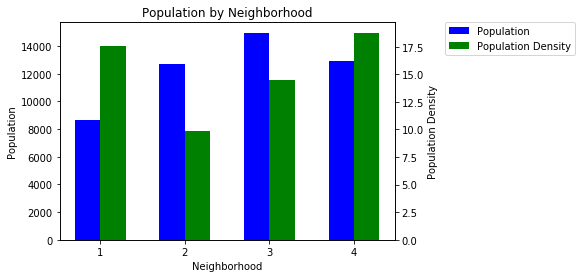

In [52]:
fig1 = plt.gcf()
x = np.arange(4)
ax1 = plt.subplot(1,1,1)
w = 0.3
plt.xticks(x + w /2, x+1, rotation='horizontal')
plt.xlabel("Neighborhood")
pop =ax1.bar(x, ballard_profile['TOTAL_POPULATION'], width=w, color='b', align='center')
plt.ylabel('Population')
ax2 = ax1.twinx()
den =ax2.bar(x + w, ballard_profile['POP_DENSITY_ACRE'], width=w,color='g',align='center')
plt.ylabel('Population Density')
lgd=plt.legend([pop, den],['Population', 'Population Density'],bbox_to_anchor=(1.15, 1), loc=2, borderaxespad=0.)
plt.title('Population by Neighborhood')

plt.show()
fig1.savefig('C:\\Users\\trang\Downloads\pop_ballard.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

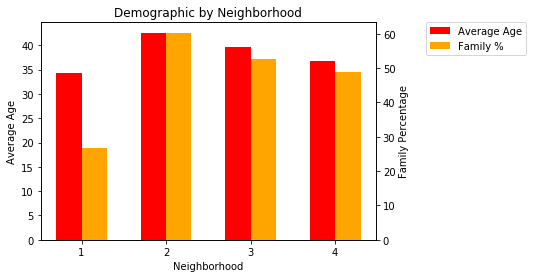

In [54]:
fig2 = plt.gcf()
x = np.arange(4)
ax1 = plt.subplot(1,1,1)
w = 0.3
plt.xticks(x + w /2, x+1, rotation='horizontal')
plt.xlabel("Neighborhood")
pop =ax1.bar(x, ballard_profile['MEDIAN_AGE'], width=w, color='r', align='center')
plt.ylabel('Average Age')
ax2 = ax1.twinx()
den =ax2.bar(x + w, ballard_profile['PCT_FAM_HH'], width=w,color='orange',align='center')
plt.ylabel('Family Percentage')
lgd=plt.legend([pop, den],['Average Age', 'Family %'],bbox_to_anchor=(1.15, 1), loc=2, borderaxespad=0.)
plt.title('Demographic by Neighborhood')

plt.show()
fig2.savefig('C:\\Users\\trang\Downloads\demo_ballard.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

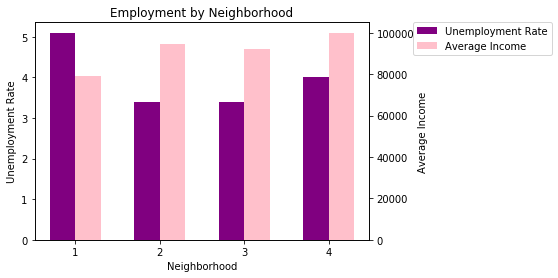

In [59]:
fig3 = plt.gcf()
x = np.arange(4)
ax1 = plt.subplot(1,1,1)
w = 0.3
plt.xticks(x + w /2, x+1, rotation='horizontal')
plt.xlabel("Neighborhood")
pop =ax1.bar(x, ballard_profile['PERCENT_UNEMPLOYED'], width=w, color='purple', align='center')
plt.ylabel('Unemployment Rate')
ax2 = ax1.twinx()
den =ax2.bar(x + w, ballard_profile['MEDIAN_HH_INC_PAST_12MO_DOLLAR'], width=w,color='pink',align='center')
plt.ylabel('Average Income')
plt.legend([pop, den],['Unemployment Rate', 'Average Income'],bbox_to_anchor=(1.13, 1), loc=2, borderaxespad=0.)
plt.title('Employment by Neighborhood')

plt.show()
fig3.savefig('C:\\Users\\trang\Downloads\employ_ballard.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [43]:
nb4.groupby('Venue Category')['Venue Category'].count()

Venue Category
Caribbean Restaurant       1
Food                       1
Food Truck                 3
French Restaurant          1
Greek Restaurant           1
Italian Restaurant         1
Mexican Restaurant         1
Pizza Place                2
Restaurant                 1
Sandwich Place             1
Scandinavian Restaurant    1
Taco Place                 1
Thai Restaurant            2
Vietnamese Restaurant      2
Name: Venue Category, dtype: int64

In [74]:
venue_summary = pd.crosstab(ballard_info2['Venue Category'],ballard_info2.Neighborhood)
venue_summary.to_csv('C:\\Users\\trang\Downloads\sum.csv', index=True)

In [66]:
venue_summary

Neighborhood,"Ballard, West Woodland, Adams","Crown Hill, North Beach, Blue Ridge","Sunset Hill, Golden Gardens, Loyal Heights, Shilshole","Whittier Heights, Loyal Heights, Crown Hill"
Venue Category,,,,
American Restaurant,1,2,1,0
Asian Restaurant,0,2,0,0
BBQ Joint,2,1,1,0
Burger Joint,5,1,2,0
Caribbean Restaurant,0,0,0,1
Chinese Restaurant,1,1,0,0
Dim Sum Restaurant,0,1,0,0
Diner,0,0,1,0
Food,0,0,2,1


In [45]:
nb1.groupby('Venue Category')['Venue Category'].count()

Venue Category
American Restaurant              1
BBQ Joint                        2
Burger Joint                     5
Chinese Restaurant               1
Food Truck                       2
French Restaurant                1
Hot Dog Joint                    1
Indian Restaurant                1
Italian Restaurant               2
Latin American Restaurant        1
Mediterranean Restaurant         1
Mexican Restaurant               6
New American Restaurant          5
Pizza Place                      2
Poke Place                       1
Sandwich Place                   6
Seafood Restaurant               3
Sushi Restaurant                 4
Tapas Restaurant                 1
Thai Restaurant                  2
Vegetarian / Vegan Restaurant    1
Vietnamese Restaurant            2
Name: Venue Category, dtype: int64

In [75]:
nb2.groupby('Venue Category')['Venue Category'].count()

Venue Category
American Restaurant          2
Asian Restaurant             2
BBQ Joint                    1
Burger Joint                 1
Chinese Restaurant           1
Dim Sum Restaurant           1
Food Truck                   1
Greek Restaurant             1
Latin American Restaurant    1
Mediterranean Restaurant     1
Mexican Restaurant           2
Moroccan Restaurant          1
Pizza Place                  7
Sandwich Place               1
Thai Restaurant              1
Vietnamese Restaurant        1
Name: Venue Category, dtype: int64

In [76]:
nb3.groupby('Venue Category')['Venue Category'].count()

Venue Category
American Restaurant          1
BBQ Joint                    1
Burger Joint                 2
Diner                        1
Food                         2
Food & Drink Shop            1
French Restaurant            1
Italian Restaurant           1
Kebab Restaurant             1
Korean Restaurant            1
Mexican Restaurant           2
Middle Eastern Restaurant    1
Pizza Place                  2
Restaurant                   2
Taco Place                   1
Name: Venue Category, dtype: int64

In [ ]:
pd.set_option('display.max_columns',25)